In [89]:
from signal_utils import *

In [90]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class RFProcessingConfig:
    delay_kernel: List[float]
    i_delay_delta: float
    q_delay_delta: float
    osr: int
    AdB_osr: float
    Fmax: float
    cpp_path: str
    quant_type: str
    deltaSigmaFactor: float
    lut_n: str
    lut: List[List[int]]
    testShow: bool
    delayShow: bool
    osrShow: bool
    deltaSigmaShow: bool
    serialShow: bool
    rfiqShow: bool

In [86]:
def plotFigure(x, x_range, title="", AdB=None, freq_factor=None, y_range=None):
    freqs, xfftdB, angle = fftdB(x, win=True)
    if freq_factor:
        freqs *= freq_factor
    xmin = x_range[0]
    xmax = x_range[1]
    plt.title(title)
    plt.plot(freqs, xfftdB)
    if AdB:
        plt.plot([xmin, xmax], [-AdB, -AdB], '--r')
    plt.xlim([xmin, xmax])
    if y_range:
        plt.ylim([y_range[0], y_range[1]])
    plt.xlabel("f/fs")
    plt.ylabel("|X|dB")
    plt.grid()
    plt.show();    

def delay_taylor_first(x, delta):
    dx = np.gradient(x)
    return x + dx*delta
    
def process(x: np.ndarray, config: RFProcessingConfig) -> np.ndarray:
    lut_width = len(config.lut[0])
    xi = x.real
    xq = x.imag

    if config.testShow:
        x_range = [-0.5, 0.5]
        plotFigure(x[config.delay_order//2:-config.delay_order//2], x_range, title=f"Test Signal", AdB=None)

    # # Taylor Delay
    # i_delta = 1/lut_width * 1/config.osr * config.i_delay_delta
    # q_delta = 1/lut_width * 1/config.osr * config.q_delay_delta

    # xi_delay = delay_taylor(xi, i_delta, config.delay_order)
    # xq_delay = delay_taylor(xq, q_delta, config.delay_order)
    # x_delay = xi_delay + 1j*xq_delay

    # First order Taylor Delay
    i_delta = 1/lut_width * 1/config.osr * config.i_delay_delta
    q_delta = 1/lut_width * 1/config.osr * config.q_delay_delta

    xi_delay = delay_taylor_first(x, i_delta)
    xq_delay = delay_taylor_first(x, q_delta)
    x_delay = xi_delay + 1j*xq_delay
    

    if config.delayShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_delay[config.delay_order//2:-config.delay_order//2], x_range, title=f"Delayed Signal, Taylor order = {config.delay_order}", AdB=None)

    # Interpolation
    deltaPass = 10**(-config.AdB_osr/20)
    deltaStop = deltaPass
    delta_interpolation = [deltaPass, deltaStop]
    F_interpolation = [config.Fmax, 1-config.Fmax]

    xi_osr = np.real(interpolate(xi_delay[config.delay_order//2:-config.delay_order//2], config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    xq_osr = np.real(interpolate(xq_delay[config.delay_order//2:-config.delay_order//2], config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    x_osr = xi_osr + 1j*xq_osr

    if config.osrShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_osr, x_range, freq_factor=1, title=f"Interpolated Signal, OSR = {osr}, AdB = {config.AdB_osr}", AdB=config.AdB_osr)

    # Delta-Sigma modulation
    xi_in_path = "./data/serial/xr_in.txt"
    xq_in_path = "./data/serial/xi_in.txt"
    xi_out_path = "./data/serial/xr_out.txt"
    xq_out_path = "./data/serial/xi_out.txt"
    iir_path = "../data/input/deltaSigma_iirs.txt"

    tmp = config.deltaSigmaFactor/np.max(xi_osr)
    xi_deltaSigma_in = np.array(xi_osr) * tmp
    xq_deltaSigma_in = np.array(xq_osr) * tmp
    
    np.savetxt(xi_in_path, xi_deltaSigma_in, fmt="%.18e")
    np.savetxt(xq_in_path, xq_deltaSigma_in, fmt="%.18e")
    
    subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, iir_path, config.quant_type])  # Call the C++ program with input and output file paths as arguments
    
    xi_deltaSigma = np.round(np.loadtxt(xi_out_path))
    xq_deltaSigma = np.round(np.loadtxt(xq_out_path))
    x_deltaSigma = xi_deltaSigma + 1j*xq_deltaSigma

    if config.deltaSigmaShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_deltaSigma, x_range, title=f"Delta-Sigma Modulated Signal", AdB=None)

    # Serialization
    xi_1b = convert_1b(xi_deltaSigma, config.lut, config.quant_type)
    xq_1b = convert_1b(xq_deltaSigma, config.lut, config.quant_type)
    x_1b = xi_1b + 1j*xq_1b

    if config.serialShow:
        x_range = np.array([-0.5, 0.5])/lut_width
        plotFigure(x_1b, x_range, title=f"Serialized Signal, LUT = {int(config.lut_n)}", AdB=None)

    # RFIQ
    x_rfiq = rfiq(xi_1b, xq_1b)

    if config.rfiqShow:
        x_range = np.array([-0.5, 0.5])/lut_width + 1
        plotFigure(x_rfiq, x_range, title=f"Reconstructed RF Signal", AdB=None, freq_factor=4, y_range=[-130, 5])

    return x_rfiq

def process_all(x: np.ndarray, config: RFProcessingConfig) -> np.ndarray:
    lut_width = len(config.lut[0])
    xi = x.real
    xq = x.imag

    if config.testShow:
        x_range = [-0.5, 0.5]
        plotFigure(x, x_range, title=f"Test Signal", AdB=None)

    # Taylor 1st Order Delay
    i_delta = 1/lut_width * 1/config.osr * config.i_delay_delta
    q_delta = 1/lut_width * 1/config.osr * config.q_delay_delta

    xi_delay = frac_delay_1st(xi, i_delta, config.delay_kernel)
    xq_delay = frac_delay_1st(xq, q_delta, config.delay_kernel)
    x_delay = xi_delay + 1j*xq_delay

    if config.delayShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_delay, x_range, title=f"Delayed Signal", AdB=None)

    # xi_delay /= np.max(xi_delay)
    # xi_delay = xi_delay[config.delay_order//2:-config.delay_order//2]
    # xq_delay /= np.max(xq_delay)
    # xq_delay = xq_delay[config.delay_order//2:-config.delay_order//2]

    # Interpolation
    deltaPass = 10**(-config.AdB_osr/20)
    deltaStop = deltaPass
    delta_interpolation = [deltaPass, deltaStop]
    F_interpolation = [config.Fmax, 1-config.Fmax]

    xi_osr = np.real(interpolate(xi, config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    xq_osr = np.real(interpolate(xq, config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    x_osr = xi_osr + 1j*xq_osr

    if config.osrShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_osr, x_range, freq_factor=1, title=f"Interpolated Signal, OSR = {osr}, AdB = {config.AdB_osr}", AdB=config.AdB_osr)

    # tmp = np.max(np.abs(x_osr))
    # tmp = np.max(xi_osr)
    # xi_osr /= tmp * 4
    # xq_osr /= tmp * 4

    tmp = 1/np.max(xi_osr)
    xi_osr *= tmp
    xq_osr *= tmp

    # Delta-Sigma modulation
    xi_in_path = "./data/serial/xi_in.txt"
    xq_in_path = "./data/serial/xq_in.txt"
    x_out_path = "./data/serial/x_out.txt"
    fir_path = "../data/input/polyFirCofficients_100dB.txt"
    iir_path = "../data/input/deltaSigma_iirs.txt"
    lut_path = "../data/input/LUT3.txt"

    xi_out_path = "./data/serial/xi_out.txt"
    xq_out_path = "./data/serial/xq_out.txt"
    
    np.savetxt(xi_in_path, xi_osr, fmt="%.18e")
    np.savetxt(xq_in_path, xq_osr, fmt="%.18e")

    subprocess.run([cpp_path, xi_in_path, xq_in_path, x_out_path, fir_path, iir_path, lut_path, config.quant_type])  # Call the C++ program with input and output file paths as arguments
    # subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, fir_path, iir_path, lut_path, config.quant_type])  # Call the C++ program with input and output file paths as arguments

    # xi_out = np.round(np.loadtxt(xi_out_path))
    # xq_out = np.round(np.loadtxt(xq_out_path))
    # x_out = xi_out + 1j*xq_out

    # x_range = np.array([-0.5, 0.5])/lut_width
    # plotFigure(x_out, x_range, title=f"Reconstructed RF Signal", AdB=None)
    
    x_rfiq = np.loadtxt(x_out_path)

    if config.rfiqShow:
        x_range = np.array([-0.5, 0.5])/lut_width + 1
        plotFigure(x_rfiq, x_range, title=f"Reconstructed RF Signal", AdB=None, freq_factor=4, y_range=[-130, 5])
    
    return x_rfiq

def find_SNR(x, f):
    freqs, x_rfiqdB, anle = fftdB(x_rfiq)
    freqs *= 4
    f_low, f_high = f[0], f[1]
    idx_band = np.where((freqs >= f_low) & (freqs <= f_high))[0]
    xdB = x_rfiqdB[idx_band]
    N = len(xdB)
    max1 = np.max(xdB[:N//2-1])
    max2 = np.max(xdB[N//2:])
    # plt.plot(xdB)
    return np.min([max1, max2])


def moving_average(x, N):
    return np.convolve(x, np.ones(N)/N, mode='valid')

In [87]:
N = 1024*8
F = 200/N
perc = 0.15
Fmax = 0.5 * (1 - perc)

k3 = np.array([0.5, 0.0, -0.5])
k5 = np.array([-1, 8, 0, -8, +1]) / 12.0
k7 = np.array([1, -9, +45, 0, -45, +9, -1]) / 60.0
k9 = np.array([-1, 12, -39, +56, 0, -56, +39, -12, +1]) / 280.0
i_delta = 1/2
q_delta = 1/4


osr = 8
AdB_osr = 100

cpp_path = "../build/rf-process" #"../build/delta-sigma"
quant_type = 'mid-tread'

LUT_n = "3"
LUT = LUTs[int(LUT_n)-1]

x_test = 1.0 * np.exp(1j*2*np.pi*F*np.arange(N))

config = RFProcessingConfig(
    delay_kernel = k7,
    i_delay_delta = i_delta,
    q_delay_delta = q_delta,
    osr = osr,
    AdB_osr = AdB_osr,
    Fmax = Fmax,
    cpp_path = cpp_path,
    quant_type = quant_type,
    deltaSigmaFactor = 4,
    lut_n = LUT_n,
    lut = LUT,
    testShow = True,
    delayShow = True,
    osrShow = True,
    deltaSigmaShow = True,
    serialShow = True,
    rfiqShow = True,
)

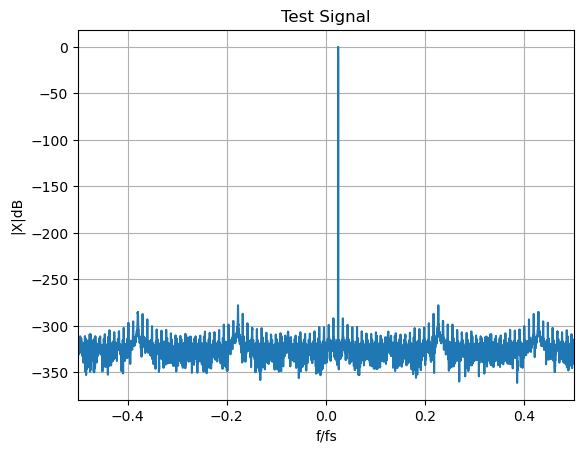

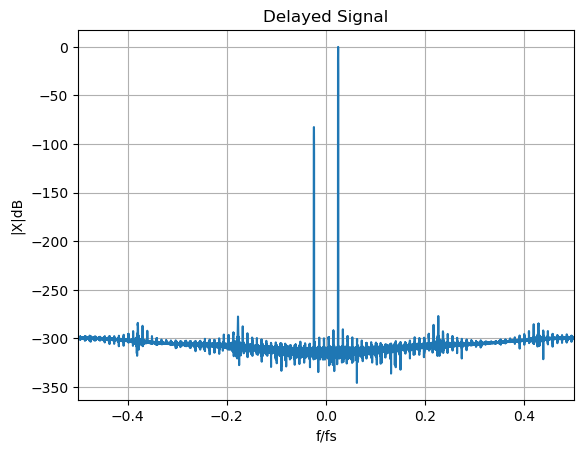

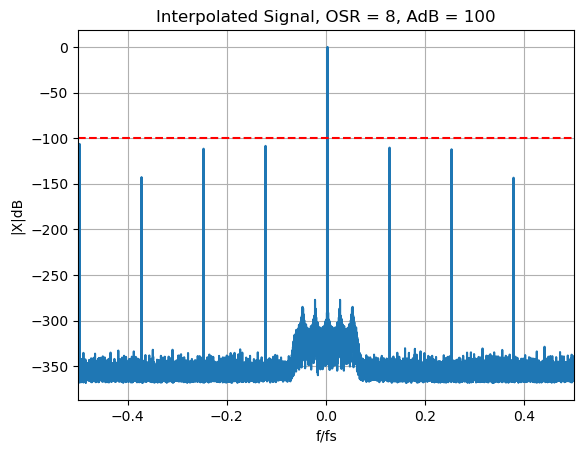

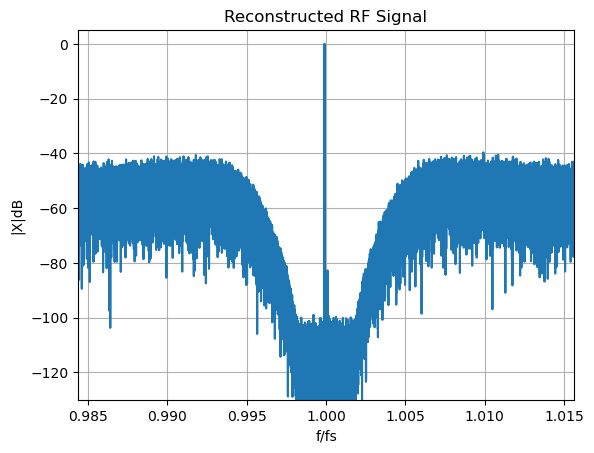

In [88]:
x_rfiq = process_all(x_test, config)

In [85]:
N = 512
Fs = np.arange(5, N//2 - 1) / N

config.delay_kernel = k7
config.testShow = False
config.delayShow = False
config.osrShow = False
config.deltaSigmaShow = False
config.serialShow = False
config.rfiqShow = False

SNR = []
for F in Fs:
    x_test = np.exp(1j * 2 * np.pi * F * np.arange(N))
    x_rfiq = process_all(x_test, config)
    
    factor = 0.5 / len(config.lut[0]) / config.osr
    f = [1 - factor, 1 + factor]
    snr_tmp = find_SNR(x_rfiq, f)
    SNR.append(snr_tmp)

SNRs = np.array(SNR)  # Shape: (len(orders), len(Fs))

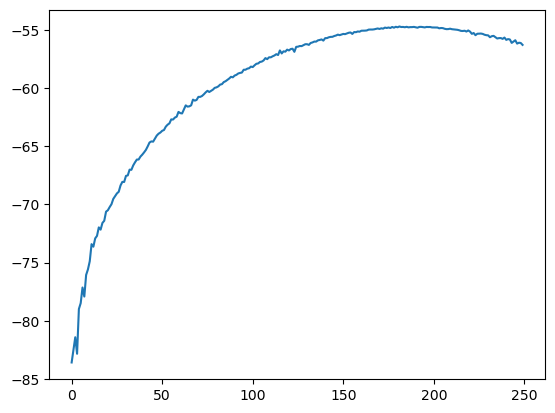

In [30]:
SNRs = np.array(SNR)
plt.plot(SNRs)

In [ ]:
k3 = np.array([0.5, 0.0, -0.5])
k5 = np.array([-1, 8, 0, -8, +1]) / 12.0
k7 = np.array([1, -9, +45, 0, -45, +9, -1]) / 60.0
k9 = np.array([-1, 12, -39, +56, 0, -56, +39, -12, +1]) / 280.0
k1_list = [k3, k5, k7, k9]

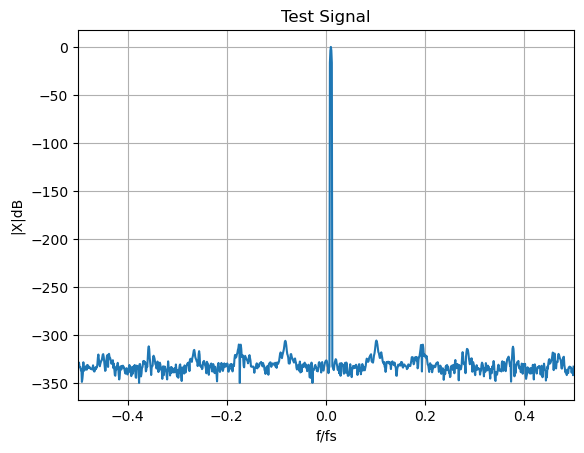

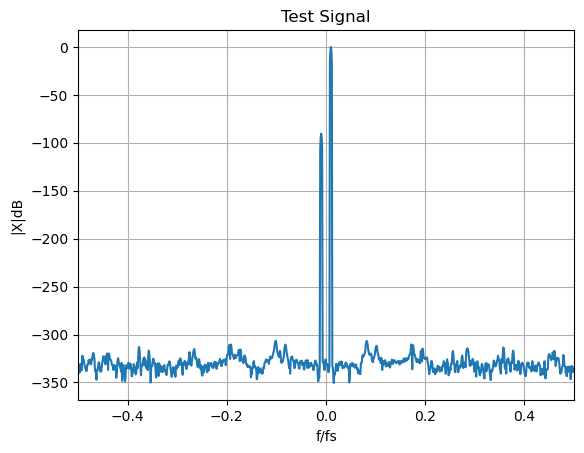

In [7]:
N = 1024
F = 10 / N
n = np.arange(N)
i_delta = 1/8/8/32
q_delta = -1/8/8/32

x = 1.0 * np.exp(1j*2*np.pi*F*n)
xi = 1.0 * np.cos(2*np.pi*F*(n+i_delta))
xq = 1.0 * np.sin(2*np.pi*F*(n+q_delta))
x_shift = xi + 1j*xq

x_range = [-0.5, 0.5]
plotFigure(x, x_range, title=f"Test Signal", AdB=None)
plotFigure(x_shift, x_range, title=f"Test Signal", AdB=None)

In [7]:
N = 256
Fs = np.arange(1, N//2 - 1) / N
orders = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

SNRs = []

for order in orders:
    config.delay_order = order
    config.testShow = False
    config.delayShow = False
    config.osrShow = False
    config.deltaSigmaShow = False
    config.serialShow = False
    config.rfiqShow = False

    SNR = []
    for F in Fs:
        x_test = np.exp(1j * 2 * np.pi * F * np.arange(N + order))
        x_rfiq = process_all(x_test, config)
        
        factor = 0.5 / len(config.lut[0]) / config.osr
        f = [1 - factor, 1 + factor]
        snr_tmp = find_SNR(x_rfiq, f)
        SNR.append(snr_tmp)

    SNRs.append(SNR)

SNRs = np.array(SNRs)  # Shape: (len(orders), len(Fs))

KeyboardInterrupt: 

In [ ]:
print(SNRs.shape)

In [ ]:
plt.figure()
for order, SNR in zip(orders, SNRs):
    # SNR_filtered = moving_average(SNR, 15)
    plt.plot(Fs, SNR, label=f"Order {order}")
# plt.show();
plt.legend()
plt.grid()
plt.xlabel("F")
plt.ylabel("SNR [dB]")
plt.savefig("snr.png")

In [ ]:
import numpy as np

def farrow_streaming(x, b_subfilters, taps, delta):
    """
    Streaming (one-sample-at-a-time) implementation of a fixed-delta Farrow delay.
    - x             : input 1D array
    - b_subfilters  : shape = (M+1, K), each row is the FIR taps aligned so that
                      index 0 corresponds to tap = taps.min(), index K-1 to tap = taps.max().
    - taps          : integer array of length K, e.g. [-2, -1, 0, 1, 2] for order=4
    - delta         : fractional delay ∈ [0,1)
    Returns y of length len(x) - (m_max - m_min), because of boundary effects.
    """

    M_plus1, K = b_subfilters.shape
    assert K == M_plus1 == len(taps), "Dimension mismatch: K must equal M+1 and len(taps)."

    m_min = int(np.min(taps))
    m_max = int(np.max(taps))
    total_span = m_max - m_min            # e.g. 4 when taps=[-2,-1,0,1,2]
    out_len = len(x) - total_span         # valid output length (e.g. 200 - 4 = 196)

    # Precompute [1, delta, delta^2, …, delta^M]
    delta_pows = np.array([delta**k for k in range(M_plus1)], dtype=float)

    # Initialize a “sliding‐window” buffer of length K to hold the last K samples.
    # buffer[0] = x[n-(K-1)], buffer[1] = x[n-(K-2)], …, buffer[K-2] = x[n-1], buffer[K-1] = x[n].
    buffer = [0.0] * K
    y = np.zeros(out_len, dtype=float)

    for n in range(len(x)):
        # 1) Push x[n] into the buffer (pop oldest, append newest)
        buffer.pop(0)
        buffer.append(float(x[n]))

        # 2) Compute the “output index” in y (this is only valid when n >= m_max)
        y_idx = n - m_max
        if y_idx < 0 or y_idx >= out_len:
            continue

        # 3) Gather the K samples needed for the FIR dot‐product.
        #    We want x[n - taps[j]] for j=0..K-1.  Since buffer[K-1] = x[n],
        #    buffer[K-2] = x[n-1],… buffer[0] = x[n-(K-1)], the index of x[n - taps[j]] in buffer is:
        #       idx_in_buffer = m_max - taps[j]
        neighborhood = np.zeros(K, dtype=float)
        for j, tap in enumerate(taps):
            idx_in_buffer = m_max - tap
            neighborhood[j] = buffer[idx_in_buffer]

        # 4) Compute each branch output s_k[n] = sum_{j=0..K-1} b_subfilters[k,j] * neighborhood[j].
        #    Since b_subfilters[k] is aligned so that index j corresponds exactly to buffer[j],
        #    we can write:
        s = b_subfilters.dot(neighborhood)   # length = M+1

        # 5) Weight by delta^k and accumulate into y[y_idx]
        y[y_idx] = np.dot(delta_pows, s)

    return y


# -----------------------------
# Example usage (order = 4)
# -----------------------------
if __name__ == "__main__":
    # 1) Design a 4th‐order Farrow filter (taps, B) exactly as before:
    def design_farrow(order):
        M = order
        if M % 2 == 0:
            L = M // 2
            taps = np.arange(-L, L+1)        # e.g. [-2, -1, 0, 1, 2]
        else:
            L = M // 2
            taps = np.arange(-L, L+2)

        taps = taps.astype(int)
        K = len(taps)   # should be M+1

        B = np.zeros((M+1, K), dtype=float)
        for i in range(K):
            denom = 1.0
            for j in range(K):
                if j == i: continue
                denom *= (taps[i] - taps[j])

            num_poly = np.array([1.0])
            for j in range(K):
                if j == i: continue
                num_poly = np.convolve(num_poly, np.array([1.0, -float(taps[j])]))

            for k in range(M+1):
                B[k, i] = num_poly[k] / denom

        return taps, B

    # 2) Build the “compact” subfilters b_subfilters so they align with buffer indices 0..(K-1).
    order = 4
    taps, B = design_farrow(order)
    m_min = taps.min()
    m_max = taps.max()
    K = len(taps)   # 5

    # b_subfilters[k, idx] corresponds to tap = (m_min + idx)
    b_subfilters = np.zeros((order+1, K), dtype=float)
    for k in range(order+1):
        for i, tap in enumerate(taps):
            idx = tap - m_min
            b_subfilters[k, idx] = B[k, i]

    # 3) Prepare a test signal and delay amount
    x = np.sin(2*np.pi*0.02*np.arange(200))  # length = 200
    delta = 0.37                             # fractional delay

    # 4) Run the streaming Farrow‐delay
    y = farrow_streaming(x, b_subfilters, taps, delta)

    print("Input length:", len(x))
    print("Output length:", len(y))
    # y[n] ≈ x[n + delta], for n = 2..(200 - 1 - (-2)) − 1 = 2..197, i.e. 196 samples total.


In [9]:
z = 1 + 1j*2
print(np.abs(z))
print(5**0.5)

2.23606797749979
2.23606797749979
